# LangGraph `:)`

## First Things First

In [2]:
# !pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python langgraph

In [33]:
import os
import random
from pprint import pprint
from google.colab import userdata
from IPython.display import display, Image
from operator import add
from typing import Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, field_validator, ValidationError
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage, SystemMessage, ToolMessage, RemoveMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [4]:
GIRU_OPENAI_API_KEY = userdata.get('GIRU_OPENAI_API_KEY')
GIRU_TAVILY_API_KEY = userdata.get('GIRU_TAVILY_API_KEY')
os.environ["OPENAI_API_KEY"] = GIRU_OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = GIRU_TAVILY_API_KEY

In [5]:
# checking openai llm
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
result = llm.invoke("Hi, are you deepseek?")

# printing results
print("==="*25)
print(f"RESPONSE\n{result.content}")
print("==="*25)
print("METADATA")
print(f"model: {result.response_metadata['model_name']}")
for k, v in result.response_metadata['token_usage'].items():
  print(f"{k}: {v}")

RESPONSE
No, I'm not DeepSeek. I'm an AI language model created by OpenAI. How can I assist you today?
METADATA
model: gpt-4o-mini-2024-07-18
completion_tokens: 25
prompt_tokens: 14
total_tokens: 39
completion_tokens_details: {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}
prompt_tokens_details: {'audio_tokens': 0, 'cached_tokens': 0}


In [6]:
# checking tavily tool
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What is LangGraph?")
search_docs

# printing results
print("==="*25)
for doc in search_docs:
  for k, v in doc.items():
    print(f"{k}: {v}")
  print("==="*25)

title: Introduction to LangGraph: A Beginner's Guide - Medium
url: https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141
content: In this article, we’ll introduce LangGraph, walk you through its basic concepts, and share some insights and common points of confusion for beginners. While LangChain allows you to define chains of computation (Directed Acyclic Graphs or DAGs), LangGraph introduces the ability to add cycles, enabling more complex, agent-like behaviors where you can call an LLM in a loop, asking it what action to take next. Step 1: Define the Graph State First, we define the state structure for our graph. Step 4: Add Nodes to the Graph LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its power for their projects.
score: 0.8467682
title: LangGraph - LangChain
url: https://www.langchain.com/langgraph
content: Bu

## Session 1: Basics

 ### Simple Graph

In [7]:
# creating simple state
class State(TypedDict):
  graph_state: str

In [8]:
# functions are passed as nodes in graphs
# creating some functions/nodes

def node_a(state: State):
  print("---Node A---")
  return {"graph_state": state['graph_state'] + "Ball Thrown By A and "}

def node_b(state: State):
  print("---Node B---")
  return {"graph_state": state['graph_state'] + "Catched By B"}

def node_c(state: State):
  print("---Node C---")
  return {"graph_state": state['graph_state'] + "Catched By C"}

In [9]:
# creating simple edges kind of DAG
# creating function which will be working as a conditional edge

def decide_mood(state):
    user_input = state['graph_state']
    if random.random() < 0.5:
        return 0
    return 1

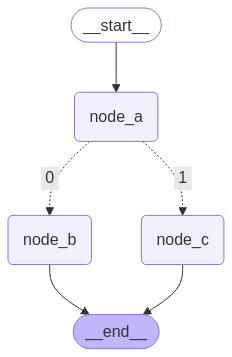

In [10]:
# first build skeleton of graph

# initialize the state
builder = StateGraph(State)

# add nodes and edges to graphs
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

builder.add_edge(START, "node_a")

builder.add_conditional_edges(
    "node_a",
    decide_mood,
    {
        0: "node_b",
        1: "node_c"
    }
)

builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

# compile the skeleton
graph = builder.compile()

# view the structure of graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke({"graph_state": "In the game of Catching Balls, "})

---Node A---
---Node B---


In [12]:
print(result['graph_state'])

In the game of Catching Balls, Ball Thrown By A and Catched By B


### Use of Messages & Tools

In [13]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Bhadwa"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Bhadwa"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Bhadwa

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Bhadwa

I want to learn about the best place to see Orcas in the US.


In [14]:
# we can convert functions into custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [15]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 times 3?")])
print(tool_call.tool_calls)

[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_yGXHyOBgYYlifrW35DNI0SNB', 'type': 'tool_call'}]


### Tool Calling Assistant

In [16]:
# tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [17]:
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [18]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

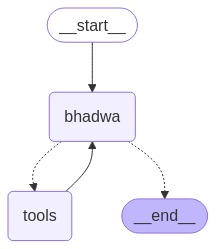

In [19]:
builder = StateGraph(MessagesState)
builder.add_node("bhadwa", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "bhadwa")

builder.add_conditional_edges(
    "bhadwa",
    tools_condition, # by default it checks whether any tool call made or not
)

builder.add_edge("tools", "bhadwa")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [21]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_FSUXJ3BEmuEqlEq61sM0ufNe)
 Call ID: call_FSUXJ3BEmuEqlEq61sM0ufNe
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_AIZcgzprhrN2zVFP77tuDxn9)
 Call ID: call_AIZcgzprhrN2zVFP77tuDxn9
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_belteAFXnbqAB9ZLt86M1AyL)
 Call ID: call_belteAFXnbqAB9ZLt86M1AyL
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

**Problem with simple Tool Calling Agent**  
It lacks memory, check below example -

In [22]:
messages = [HumanMessage(content="Add 3 and 4")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

messages = [HumanMessage(content="and multiply that by 4")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_rae7OOUUCkeumAjEv73edmFP)
 Call ID: call_rae7OOUUCkeumAjEv73edmFP
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

and multiply that by 4
================================== Ai Message ==================================

Could you please provide the number you would like to multiply by 4?


*It doesn't know what is that...*

### Tool Calling Agent with Memory

*We just simply have to add persistence via some kind of memory, below is example by using in-memory (default by langgraph)*

In [23]:
memory = MemorySaver()
react_graph_with_memory = builder.compile(checkpointer=memory)

First, we have to pass the memory into checkpointer while compiling graph.  
What it does?  
It creates a thread with some id and for that thread it stores or kind of checkpoints each node execution (not just last, instead all nodes) and hence, that thread kind of act as a memory for that session.

In [24]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_with_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_UYdxz6DOlx7psM2LNloNEYAe)
 Call ID: call_UYdxz6DOlx7psM2LNloNEYAe
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [25]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_with_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_UYdxz6DOlx7psM2LNloNEYAe)
 Call ID: call_UYdxz6DOlx7psM2LNloNEYAe
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_LnhOeLgDr36IZv6j1iE4gwht)
 Call ID: call_LnhOeLgDr36IZv6j1iE4gwht
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplying 7 by 2 gi

## Session 2: More on Validation & Reducers

### Reducers

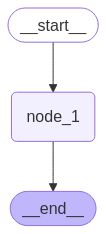

In [28]:
class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

**Below example shows that `reducer functions` helps in handling `race condtions`**

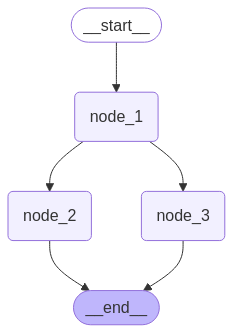

In [30]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

### More on ` messages ` and ` MessageState `  
By providing `id` to messages we can do a lot with them like updation, deletion and concatentation etc.

**Updating messages using `id`**

In [32]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

**Deleting messages using `id`**   
Here is the trick that `add_messages` reducer will recognize the `RemoveMessage` and automatically delete the message with the particular `id`

In [34]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [35]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

Hence, by using this we can do trimming and filtering of messages.

### Mulitple Schemas  
Nodes can talk or share information in different states also, they don't require to always follow the same state as passed in input intitially.

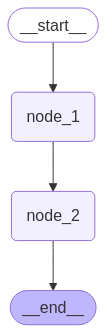

In [36]:
class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

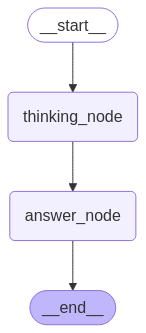

{'answer': 'bye Lance'}

In [40]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

### Chatbot with Summary Key

In [41]:
class State(MessagesState):
    summary: str

In [42]:
def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

In [43]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above"
        )
    else:
        summary_message = "Create a summary of the conversation above"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all except the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [44]:
def should_continue(state: State):
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END

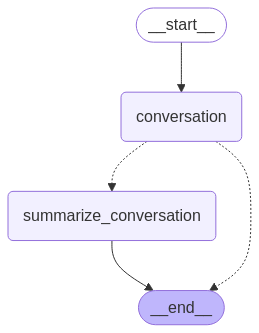

In [45]:
workflow = StateGraph(State)

workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! How can I assist you today?
================================== Ai Message ==================================

Your name is Lance! How can I help you today?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable moment from their games?


In [47]:
graph.get_state(config).values.get("summary","")

''

In [48]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

As of my last update, Nick Bosa signed a contract extension with the San Francisco 49ers in September 2023, making him one of the highest-paid defensive players in NFL history. His impact on the field has been significant, and he’s known for his exceptional skills as a pass rusher. Are you excited about the upcoming season?


In [49]:
graph.get_state(config).values.get("summary","")

"In our conversation, you introduced yourself as Lance and mentioned that you like the San Francisco 49ers. You expressed your admiration for Nick Bosa, noting that he is one of the highest-paid defensive players in the NFL following his contract extension in September 2023. We discussed Bosa's impact on the team and your excitement for the upcoming season."